# Part 2 NLP (25 pts)

The Part 2 is an in-class competition. 

Original Competition: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge 

Using the file: jigsaw-toxic-comment-classification-challenge.zip

The .zip file contains the Jigsaw Toxic Comment Classification dataset as provided in the original Kaggle competition. 
Data is organized as zip files containing .csv files. The training data is organized by ID, text, and label.


Content Warning: The dataset contains text that may be considered profane, vulgar, or offensive.


Submission Details: part2.ipynb file (Write your comments as markdown) Model and results (10 pts) + class ranking (10 pts) + report (5 pts)

review -

https://colab.research.google.com/github/kwanhong66/PyTorchKaggle/blob/master/Toxic_comment_classification_bert_simple.ipynb#scrollTo=y-G3zxj8zgVM

refernce - 
https://towardsdatascience.com/toxic-comment-classification-using-lstm-and-lstm-cnn-db945d6b7986

https://github.com/shaunak09vb/Toxic-Comment-Classifier-AWS/blob/main/source

# Step 1. Load the dataset

In [1]:
import pandas as pd
import torch

In [2]:
! rm -rf jigsaw-toxic-comment-classification-challenge
! rm -rf __MACOSX
# ! wget  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
! unzip jigsaw-toxic-comment-classification-challenge.zip


Archive:  jigsaw-toxic-comment-classification-challenge.zip
   creating: jigsaw-toxic-comment-classification-challenge/
  inflating: __MACOSX/._jigsaw-toxic-comment-classification-challenge  
  inflating: jigsaw-toxic-comment-classification-challenge/.DS_Store  
  inflating: __MACOSX/jigsaw-toxic-comment-classification-challenge/._.DS_Store  
  inflating: jigsaw-toxic-comment-classification-challenge/test_labels.csv  
  inflating: jigsaw-toxic-comment-classification-challenge/test.csv  
  inflating: jigsaw-toxic-comment-classification-challenge/train.csv  
  inflating: jigsaw-toxic-comment-classification-challenge/sample_submission.csv  


## Configurations

In [3]:

DEVICE = "cuda" if torch.cuda.is_available() else "mps"

EPOCHS = 10

EMBEDDING_DIMENSION = 300
EMBEDDING_FILE_LOCATION = 'model/wiki-news-300d-1M.vec'
DETECTION_CLASSES = [
    'toxic',
    'severe_toxic',
    'obscene',
    'threat',
    'insult',
    'identity_hate',
    'neutral']

MODEL_LOCATION = 'model/toxicity_classifier.h5'
TOKENIZER_LOCATION = 'model/tokenizer.pickle'
VALIDATION_SPLIT=0.2

## Data Loading

In [4]:
base_path = "jigsaw-toxic-comment-classification-challenge"
train_df = pd.read_csv(f'{base_path}/train.csv')

print(f"{train_df.shape = } \n")
train_df.head()

train_df.shape = (159571, 8) 



,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



# Step 2. Preprocess the data as you see fit


In [6]:
# ! mkdir model
# ! rm -rf wiki-news-300d-1M.vec.zip
# ! wget  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
# ! unzip wiki-news-300d-1M.vec.zip
# ! mv wiki-news-300d-1M.vec model/
# ! rm -rf wiki-news-300d-1M.vec.zip


In [7]:
import re
import spacy
import nltk
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import string
from string import ascii_lowercase
import matplotlib.pyplot as plt


from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')



[nltk_data] Downloading package wordnet to /Users/hims/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

{'toxic': 15294, 'severe_toxic': 1595, 'obscene': 8449, 'threat': 478, 'insult': 7877, 'identity_hate': 1405, 'neutral': 143346}


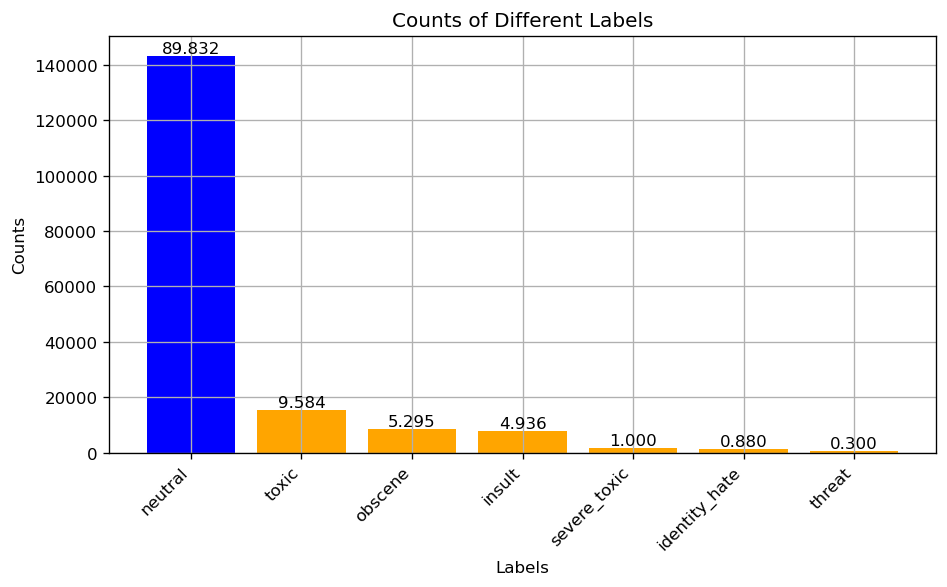

In [8]:
# Count record counts for each label
label_counts = train_df.iloc[:, 2:].sum().to_dict()
label_counts['neutral'] = len(train_df[(train_df.iloc[:, 2:] == 0).all(axis=1)])
print(label_counts)

sorted_label_counts = dict(sorted(label_counts.items(), key=lambda item: item[1], reverse=True))

# Plot the sorted bar chart with percentages on top of bars
plt.figure(figsize=(8, 5), dpi=120)
bars = plt.bar(sorted_label_counts.keys(), sorted_label_counts.values(), color=['blue' if label == 'neutral' else 'orange' for label in sorted_label_counts.keys()])

plt.xlabel('Labels')
plt.ylabel('Counts')
plt.grid(True)
plt.title('Counts of Different Labels')

# Add percentages on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 5, f'{yval/len(train_df)*100:3.3f}', ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Data Preprocessing

In [9]:
import contractions

def remove_contraction_(text):
    try:
        specials = ["’", "‘", "´", "`"]
        for s in specials:
            text = text.replace(s, "'")
        expanded_words = [] 
        for word in text.split():
            try:
                expanded_words.append(contractions.fix(word)) 
            except Exception as e:
                expanded_words.append(word)

        return ' '.join(expanded_words)
    except Exception as e:
        print(f"Error occurred during remove_contraction: {e}")
        print(f"{text = }")
        raise e

        
def remove_contraction(text):
    contraction_mapping = {"ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because",
                           "could've": "could have", "couldn't": "could not",
                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                           "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will",
                           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
                           "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
                           "I'll've": "I will have", "I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have", "i'm": "i am",
                           "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have",
                           "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us",
                           "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not",
                           "mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
                           "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                           "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
                           "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
                           "she'll've": "she will have", "she's": "she is", "should've": "should have",
                           "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                           "so's": "so as",
                           "this's": "this is", "that'd": "that would", "that'd've": "that would have",
                           "that's": "that is",
                           "there'd": "there would", "there'd've": "there would have", "there's": "there is",
                           "here's": "here is",
                           "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
                           "they'll've": "they will have",
                           "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                           "we'd": "we would", "we'd've": "we would have", "we'll": "we will",
                           "we'll've": "we will have",
                           "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
                           "what'll've": "what will have",
                           "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is",
                           "when've": "when have",
                           "where'd": "where did", "where's": "where is", "where've": "where have",
                           "who'll": "who will",
                           "who'll've": "who will have",
                           "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have",
                           "will've": "will have",
                           "won't": "will not", "won't've": "will not have", "would've": "would have",
                           "wouldn't": "would not",
                           "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                           "y'all'd've": "you all would have",
                           "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would",
                           "you'd've": "you would have", "you'll": "you will",
                           "you'll've": "you will have", "you're": "you are", "you've": "you have"}
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(" ")])
    return text

In [10]:
def clean_repeat_patterns_lower(text,remove_repeat_text=True, remove_patterns_text=True, is_lower=True):
    
    RE_PATTERNS = {
        ' american ':
            [
                'amerikan'
            ],

        ' adolf ':
            [
                'adolf'
            ],


        ' hitler ':
            [
                'hitler'
            ],

        ' fuck':
            [
                '(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
                '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
                ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f u u c',
                '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',
                'feck ', ' fux ', 'f\*\*', 'f**k','fu*k',
                'f\-ing', 'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck'
            ],

        ' ass ':
            [
                '[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$',
                '[^a-z]anus', ' a\*s\*s', '[^a-z]ass[^a-z ]',
                'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s','a55', '@$$'
            ],

        ' ass hole ':
            [
                ' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole', 'a**hole'
            ],

        ' bitch ':
            [
                'b[w]*i[t]*ch', 'b!tch',
                'bi\+ch', 'b!\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
                'biatch', 'bi\*\*h', 'bytch', 'b i t c h', 'b!tch', 'bi+ch', 'l3itch'
            ],

        ' bastard ':
            [
                'ba[s|z]+t[e|a]+rd'
            ],

        ' trans gender':
            [
                'transgender'
            ],

        ' gay ':
            [
                'gay'
            ],

        ' cock ':
            [
                '[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
                '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'
            ],

        ' dick ':
            [
                ' dick[^aeiou]', 'deek', 'd i c k', 'dik'
            ],

        ' suck ':
            [
                'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'
            ],

        ' cunt ':
            [
                'cunt', 'c u n t'
            ],

        ' bull shit ':
            [
                'bullsh\*t', 'bull\$hit'
            ],

        ' homo sex ual':
            [
                'homosexual'
            ],

        ' jerk ':
            [
                'jerk'
            ],

        ' idiot ':
            [
                'i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots'
                                                                                          'i d i o t'
            ],

        ' dumb ':
            [
                '(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'
            ],

        ' shit ':
            [
                'shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t', '$h1t'
            ],

        ' shit hole ':
            [
                'shythole'
            ],

        ' retard ':
            [
                'returd', 'retad', 'retard', 'wiktard', 'wikitud'
            ],

        ' rape ':
            [
                ' raped'
            ],

        ' dumb ass':
            [
                'dumbass', 'dubass'
            ],

        ' ass head':
            [
                'butthead'
            ],

        ' sex ':
            [
                'sexy', 's3x', 'sexuality'
            ],


        ' nigger ':
            [
                'nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'
            ],

        ' shut the fuck up':
            [
                'stfu', 'st*u'
            ],

        ' pussy ':
            [
                'pussy[^c]', 'pusy', 'pussi[^l]', 'pusses', 'p*ssy'
            ],

        ' faggot ':
            [
                'faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
                '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',
            ],

        ' mother fucker':
            [
                ' motha ', ' motha f', ' mother f', 'motherucker',
            ],

        ' whore ':
            [
                'wh\*\*\*', 'w h o r e'
            ],
        ' fucking ':
            [
                'f*$%-ing'
            ],
    }
    
    if is_lower:
        text=text.lower()

    if remove_patterns_text:
        for target, patterns in RE_PATTERNS.items():
            for pat in patterns:
                text=str(text).replace(pat, target)

    if remove_repeat_text:
        text = re.sub(r'(.)\1{2,}', r'\1', text) 

    text = str(text).replace("\n", " ")
    text = re.sub(r'[^\w\s]',' ',text)
    text = re.sub('[0-9]',"",text)
    text = re.sub(" +", " ", text)
    text = re.sub("([^\x00-\x7F])+"," ",text)
    return text 



def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"
        u"\U0001F1F2-\U0001F1F4"  
        u"\U0001F1E6-\U0001F1FF"
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# from cleantext import clean

# def remove_special_characters(text):
#     # Use the clean-text library to remove emojis and special characters
#     cleaned_text = clean(text, no_emoji=True, no_special_chars=True)
#     return cleaned_text


def prepare_stopwords_list():
    stopword_list = STOP_WORDS
    potential_stopwords = ['editor', 'reference', 'thank', 'work','find', 'good', 'know', 'like', 
                           'look', 'thing', 'want', 'time', 'list', 'section','wikipedia', 'doe', 
                           'add','new', 'try', 'think', 'write','use', 'user', 'way', 'page']
    for word in potential_stopwords:
        stopword_list.add(word)
    return(stopword_list)


def remove_stop_words(text, remove_stop=True):
    stop_words=prepare_stopwords_list()
    output = ""
    if remove_stop:
        text=text.split(" ")
        for word in text:
            if word not in stop_words:
                output=output + " " + word
    else :
        output=text  
    return str(output.strip()) 
    

def lemmatize(text, lemmatization=True):
    wordnet_lemmatizer = WordNetLemmatizer()
    output=""
    if lemmatization:
        text=text.split(" ")
        for word in text:
            word1 = wordnet_lemmatizer.lemmatize(word, pos = "n")
            word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v")
            word3 = wordnet_lemmatizer.lemmatize(word2, pos = "a")
            word4 = wordnet_lemmatizer.lemmatize(word3, pos = "r")
            output=output + " " + word4
    else:
        output=text
    return str(output.strip())    


# import spacy

# # Load the English language model
# nlp = spacy.load('en_core_web_sm')

# def lemmatize(text):
#     # Process the text using spaCy
#     doc = nlp(text)
    
#     # Lemmatize each token in the document
#     lemmatized_tokens = [token.lemma_ for token in doc]
    
#     # Join the lemmatized tokens back into a string
#     lemmatized_text = ' '.join(lemmatized_tokens)
    
#     return lemmatized_text


def clean_text(text):
    text=remove_contraction(text)
    text=clean_repeat_patterns_lower(text)
    text=remove_emojis(text)
    text=remove_stop_words(text)
    text=lemmatize(text)
    return text


def clean_text_column(text_column):
    return text_column.apply(lambda x: clean_text(x))



In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

class DataProcessing:
    def __init__(self, EMBEDDING_FILE_LOCATION, DETECTION_CLASSES,
                 max_vocab_size=100000, max_seq_length=100, embedding_dimension=300):
        self.max_vocab_size = max_vocab_size
        self.max_seq_length = max_seq_length
        self.embedding_dimension = embedding_dimension
        self.EMBEDDING_FILE_LOCATION = EMBEDDING_FILE_LOCATION
        self.tokenizer = Tokenizer(num_words=self.max_vocab_size)
        self.word_index = None
        self.embedding_layer = None

    def fit_tokenizer(self, data):
        data['comment_text'] = clean_text_column(data['comment_text'])
        self.tokenizer.fit_on_texts(data['comment_text'].values)
        self.word_index = self.tokenizer.word_index
        list_tokenized_train = self.tokenizer.texts_to_sequences(data['comment_text'].values)
        X_t = pad_sequences(list_tokenized_train, maxlen=self.max_seq_length, padding='post')
        return X_t
        
    def get_tokenizer(self):
        return self.tokenizer

    def get_embedding_layer(self):
        # Load pre-trained embeddings
        embeddings_index_fasttext = {}
        with open(self.EMBEDDING_FILE_LOCATION, encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                embeddings_index_fasttext[word] = np.asarray(values[1:], dtype='float32')

        # Create embedding matrix
        embedding_matrix_fasttext = np.random.random((len(self.word_index) + 1, self.embedding_dimension))
        for word, i in self.word_index.items():
            embedding_vector = embeddings_index_fasttext.get(word)
            if embedding_vector is not None:
                embedding_matrix_fasttext[i] = embedding_vector

        # Initialize embedding layer
        self.embedding_layer = nn.Embedding(len(self.word_index) + 1, self.embedding_dimension)
        self.embedding_layer.weight = nn.Parameter(torch.Tensor(embedding_matrix_fasttext))
        return self.embedding_layer
    
    

    def tokenize(self, data):
        data['comment_text'] = clean_text_column(data['comment_text'])
        list_tokenized = self.tokenizer.texts_to_sequences(data['comment_text'].values)
        X_t = pad_sequences(list_tokenized, maxlen=self.max_seq_length, padding='post')
        return X_t
    
    
    def tokenize_string(self, text):
        text = clean_text(text)
        print(text)
        list_tokenized = self.tokenizer.texts_to_sequences([text])
        X_t = pad_sequences(list_tokenized, maxlen=self.max_seq_length, padding='post')
        return X_t


In [35]:
BATCH_SIZE = 32

def get_train_test_data(X_t, train_df):
    
    data_tensor = torch.tensor(X_t, dtype=torch.long).to(DEVICE)
    target_tensor = torch.tensor(train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values, 
                                 dtype=torch.float)

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(data_tensor, target_tensor, test_size=VALIDATION_SPLIT)
    

    # Create DataLoader for training and validation sets
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    return train_loader, val_loader

In [ ]:
def load_test_data():
    df1 = pd.read_csv(f'{base_path}/test.csv')
    df2 = pd.read_csv(f'{base_path}/test_labels.csv')

    df_test = pd.merge(df1, df2, on='id', how='inner')

    # removing sample with labels equal to -1
    df_test = df_test.loc[df_test['toxic'] >= 0]
    df_test.reset_index(inplace=True)
    df_test = df_test.drop(columns=['index'])
    # print(df_test.head())
    print("test shape = ", df_test.shape)
    # print(df_test.head(10))
    return df_test



df_test = load_test_data()

# df_test['comment_text'] = clean_text_column(df_test['comment_text'])
X_test = processor.tokenize(df_test)


# Convert data to PyTorch tensors
test_data_tensor = torch.tensor(X_test, dtype=torch.long)
test_target_tensor = torch.tensor(df_test[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values, dtype=torch.float)

test_dataset = TensorDataset(test_data_tensor, test_target_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


# Step 3. Utilize a model implementing a Natural Language Processing strategy


In [13]:
class LSTMModel(nn.Module):
    
    def __init__(self, embedding_layer, num_classes, hidden_size=40, dropout=0.1):
        super(LSTMModel, self).__init__()
        self.embedding_layer = embedding_layer
        self.lstm = nn.LSTM(embedding_layer.embedding_dim, hidden_size, batch_first=True)
        self.global_max_pooling = nn.AdaptiveMaxPool1d(1)
        self.dropout1 = nn.Dropout(dropout)
        self.dense1 = nn.Linear(hidden_size, 30)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.dense2 = nn.Linear(30, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded_sequences = self.embedding_layer(x)
        lstm_output, _ = self.lstm(embedded_sequences)
        global_max_pooled = self.global_max_pooling(lstm_output.permute(0, 2, 1))
        x = self.dropout1(global_max_pooled.squeeze(2))
        x = self.relu(self.dense1(x))
        x = self.dropout2(x)
        x = self.dense2(x)
        return self.sigmoid(x)
    
model = LSTMModel(embedding_layer, num_classes=6).to(DEVICE)
print(model)
summary(model)

# Step 4. Train your model.


In [75]:
def plot_training_metrics(training_metric):
    num_epochs = len(training_metric['train_loss'])
    epochs = np.arange(1, num_epochs + 1)  # Assuming start from 1, adjust if needed

    # Plotting side by side without epoch axis
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

    # Plot g_loss
    axs[0].plot(epochs, training_metric['train_loss'], marker='o')
    axs[0].set_title('train loss')
    axs[0].set_xlabel('Epochs')
    axs[0].grid(True)

    axs[1].plot(epochs, training_metric['val_loss'], marker='o')
    axs[1].set_title('val loss')
    axs[1].set_xlabel('Epochs')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


In [70]:
from tqdm import tqdm  # Import tqdm for progress tracking
import torch.optim as optim



def train(train_loader, val_loader, model, criterion, optimizer, num_epochs):
    
    print("Started training")
    training_metrics = {"train_loss": [], "val_loss": []}
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation loop
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()

        print(f'Epoch {epoch + 1}/{EPOCHS}, Loss: {running_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}')
        
        training_metrics["train_loss"].append(running_loss / len(train_loader))
        training_metrics["val_loss"].append(val_loss / len(val_loader))

    plot_training_metrics(training_metrics)    
    return training_metrics, model

In [16]:
processor = DataProcessing(EMBEDDING_FILE_LOCATION, DETECTION_CLASSES)
X_t = processor.fit_tokenizer(train_df)
print("Processed Data Tokens")

Processed Data Tokens


In [17]:

train_loader, val_loader = get_train_test_data(X_t, train_df)
embedding_layer = processor.get_embedding_layer()
model = LSTMModel(embedding_layer, num_classes=6).to(DEVICE)

optimizer = optim.Adam(G.parameters(), lr=0.001, betas=(0.9, 0.999))

training_metrics, model = train(train_loader, val_loader, 
                                        model, criterion = nn.BCELoss(), 
                                        optimizer = optim.Adam(model.parameters()), 
                                        num_epochs = 10)

Started training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3990/3990 [04:06<00:00, 16.16it/s]


Epoch 1/10, Loss: 0.0620, Val Loss: 0.0479


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3990/3990 [03:58<00:00, 16.74it/s]


Epoch 2/10, Loss: 0.0438, Val Loss: 0.0472


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3990/3990 [03:51<00:00, 17.22it/s]


Epoch 3/10, Loss: 0.0366, Val Loss: 0.0481


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3990/3990 [03:49<00:00, 17.36it/s]


Epoch 4/10, Loss: 0.0310, Val Loss: 0.0534


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3990/3990 [03:41<00:00, 18.01it/s]


Epoch 5/10, Loss: 0.0267, Val Loss: 0.0566


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3990/3990 [03:36<00:00, 18.42it/s]


Epoch 6/10, Loss: 0.0229, Val Loss: 0.0636


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3990/3990 [03:31<00:00, 18.88it/s]


Epoch 7/10, Loss: 0.0203, Val Loss: 0.0697


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3990/3990 [03:27<00:00, 19.27it/s]


Epoch 8/10, Loss: 0.0177, Val Loss: 0.0772


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3990/3990 [03:26<00:00, 19.31it/s]


Epoch 9/10, Loss: 0.0156, Val Loss: 0.0885


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3990/3990 [03:24<00:00, 19.55it/s]


Epoch 10/10, Loss: 0.0138, Val Loss: 0.0923


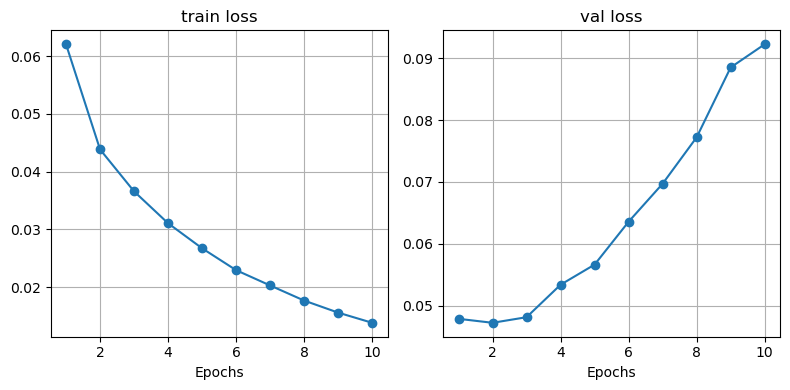

# Step 5. Display the results of your model on the Test dataset by showing the predicted labels against their true labels

In [78]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score


def evaluate(model, loader):
    predicted = []
    actual = []
    flag = False
    with torch.no_grad():
        for inputs, labels in tqdm(loader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            predicted.extend(outputs)
            actual.extend(labels)
            if flag:
                flag = False
                print(inputs)
                print(outputs)
                
    # print(predicted[0], '\n', actual[0])
        
    predicted = [tensor.cpu().numpy() for tensor in predicted]
    actual = [tensor.cpu().numpy() for tensor in actual]
    print(predicted[:5])
    threshold = 0.5
    predicted_classes = [[1 if val >= threshold else 0 for val in output] for output in predicted]
    
    precision, recall, f1, accuracy, roc_auc = [], [], [], [], []

    for i in tqdm(range(len(actual[0]))):
        precision.append(precision_score([row[i] for row in actual], [row[i] for row in predicted_classes]))
        recall.append(recall_score([row[i] for row in actual], [row[i] for row in predicted_classes]))
        f1.append(f1_score([row[i] for row in actual], [row[i] for row in predicted_classes]))
        accuracy.append(accuracy_score([row[i] for row in actual], [row[i] for row in predicted_classes]))
        roc_auc.append(roc_auc_score([row[i] for row in actual], [row[i] for row in predicted]))

    # Create a DataFrame to display the metrics
    metrics_df = pd.DataFrame({
        'Class':     [DETECTION_CLASSES[i] for i in list(range(len(actual[0])))] + ['average'],
        'Precision': precision + [np.mean(precision)],
        'Recall':    recall + [np.mean(recall)],
        'F1-score':  f1 + [np.mean(f1)],
        'Accuracy':  accuracy + [np.mean(accuracy)],
        'ROC AUC':   roc_auc + [np.mean(roc_auc)]
    })

    # print(metrics_df.head(10))
    return metrics_df
    
    
metrics_df = evaluate(model, val_loader)
metrics_df

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 998/998 [00:07<00:00, 128.71it/s]


[array([1.78271075e-05, 1.08270680e-22, 1.25917115e-11, 1.04388492e-12,
       2.00304306e-08, 1.09317710e-08], dtype=float32), array([2.0199071e-04, 9.1913169e-20, 3.2026215e-10, 2.0494224e-11,
       1.5666544e-07, 1.2932192e-07], dtype=float32), array([1.00667705e-07, 1.83037466e-19, 2.68459255e-09, 2.00544381e-08,
       5.50704229e-08, 1.34629623e-08], dtype=float32), array([4.1191089e-01, 1.1314127e-14, 1.3426081e-05, 5.9399700e-11,
       5.8214630e-07, 1.6528462e-07], dtype=float32), array([2.2320203e-09, 1.3860707e-23, 4.9011209e-08, 7.6442357e-13,
       8.2107290e-12, 7.4075490e-13], dtype=float32)]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 12.44it/s]


,Class,Precision,Recall,F1-score,Accuracy,ROC AUC
0,toxic,0.694220,0.741208,0.716945,0.944728,0.953376
1,severe_toxic,0.529644,0.404834,0.458904,0.990099,0.984247
2,obscene,0.809675,0.770909,0.789817,0.978787,0.983505
3,threat,0.462963,0.233645,0.310559,0.996522,0.946305
4,insult,0.691030,0.670103,0.680406,0.969387,0.973660
5,identity_hate,0.549550,0.420690,0.476562,0.991603,0.972702
6,average,0.622847,0.540231,0.572199,0.978521,0.968966


In [61]:
def load_test_data():
    df1 = pd.read_csv(f'{base_path}/test.csv')
    df2 = pd.read_csv(f'{base_path}/test_labels.csv')
    df_test = pd.merge(df1, df2, on='id', how='inner')
    
    cols = df_test.columns[2:]
    df_test = df_test[(df_test[cols] != -1).all(axis=1)]
    df_test.reset_index(inplace=True)
    df_test = df_test.drop(columns=['index'])
    
    print("test shape = ", df_test.shape)
    return df_test



def get_labels(text, model):
    seq = processor.tokenize_string(text)
    predicted = model(torch.tensor(seq).to(DEVICE))
    predicted_classes = [[1 if val >= 0.5 else 0 for val in output] for output in predicted]
    return [DETECTION_CLASSES[i] for i, x in enumerate(predicted_classes[0]) if x == 1]



def show_sample_predicted_labels(df_test, model):
    filtered_df = df_test[(df_test.iloc[:, 2:].sum(axis=1) > 1)].copy()
    print(f"Filtered DF size = {len(filtered_df)}")

    # Concatenate labels into a single string using apply and lambda
    filtered_df['labels'] = filtered_df.apply(lambda row: ','.join(row.index[2:][row[2:] > 0]), axis=1)

    # Create new DataFrame with comment_text and labels
    selected_df = filtered_df[['comment_text', 'labels']].head(5)
    selected_df.rename(columns={'labels': 'actual_labels'}, inplace=True)
    pd.set_option('display.max_colwidth', None)
    selected_df['predicted_label'] = selected_df['comment_text'].apply(lambda x: get_labels(x, model))
    return selected_df
    

    
def evalue_model_on_test(model):
    df_test = load_test_data()

    X_test = processor.tokenize(df_test.copy())
    test_data_tensor = torch.tensor(X_test, dtype=torch.long)
    test_target_tensor = torch.tensor(df_test[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values, 
                                      dtype=torch.float)

    test_dataset = TensorDataset(test_data_tensor, test_target_tensor)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    metrics_df = evaluate(model, test_loader)
    tagged_df = show_sample_predicted_labels(df_test, model)
    return metrics_df, tagged_df
    
    
metrics_df, tagged_df = evalue_model_on_test(model)
metrics_df

test shape =  (63978, 8)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  5.85it/s]


Filtered DF size = 4401
dj robinson gay hell suck dick
fuck anti semitic cunt
arrogant self serve immature idiot right
suck university nicknameless ncaa history happen
argh random idiot delete japan article


,Class,Precision,Recall,F1-score,Accuracy,ROC AUC
0,toxic,0.497492,0.797865,0.612852,0.904045,0.943886
1,severe_toxic,0.295053,0.455041,0.357985,0.990637,0.980161
2,obscene,0.591028,0.735302,0.655318,0.955375,0.968259
3,threat,0.322751,0.289100,0.305000,0.995655,0.960385
4,insult,0.543758,0.654508,0.594015,0.952077,0.957164
5,identity_hate,0.462733,0.418539,0.439528,0.988121,0.966005
6,average,0.452136,0.558393,0.494116,0.964318,0.962643


In [60]:
tagged_df

,comment_text,actual_labels,predicted_label
24,DJ Robinson is gay as hell! he sucks his dick so much!!!!!,"toxic,obscene,insult,identity_hate","[toxic, obscene]"
29,":Fuck off, you anti-semitic cunt. |","toxic,obscene,insult","[toxic, severe_toxic, obscene, insult]"
40,"::No, he is an arrogant, self serving, immature idiot. Get it right.","toxic,obscene,insult","[toxic, insult]"
106,"::::Well, it sucks to have a university to be nicknameless. And it's the first time in NCAA history that it has happened. /","toxic,obscene",[obscene]
107,== Argh == \n\n Some random idiot deleted the whole Japan article <.,"toxic,obscene,insult","[toxic, obscene, insult]"


# Other Models